<a href="https://colab.research.google.com/github/MaulanaHasyim/MaulanaHasyim/blob/main/notebooks/Test%20Klasifikasi%20Suicide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Deskripsi Project: Komparasi Multinomial Naive Bayes dan Decision Tree untuk Klasifikasi Teks Potensial Suicidal pada Media Sosial X dengan Optimalisasi Hyperparameter Tuning**

Project ini bertujuan untuk mengembangkan sistem klasifikasi berbasis machine learning guna mendeteksi konten potensial suicidal pada platform media sosial, khususnya Twitter/X. Dataset yang digunakan didapatkan melalui laman kaggle yang terdiri dari data tweet yang telah dianotasi sebagai Potential Suicide post atau Not Suicide post.

#**0. Import Library**

In [1]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 6.1 MB/s eta 0:00:00


In [2]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.7 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import string
import re
import emoji
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import joblib

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, learning_curve
from sklearn.utils import shuffle
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from skopt import BayesSearchCV

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# **1. Reading Data**

Dataset yang digunakan dalam proyek ini diperoleh dari platform Kaggle. Dataset ini terdiri dari dua kolom utama:

Kolom "Tweet": Berisi teks yang diambil dari platform Twitter. Teks ini mencerminkan berbagai macam tweet, mulai dari pernyataan umum hingga potensi indikasi ideasi suicidal.

Kolom "Suicide": Berisi label klasifikasi dengan dua kategori, yaitu:  "Potential Suicide post" dan "Not Suicide post"

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aunanya875/suicidal-tweet-detection-dataset")

print("Path to dataset files:", path)

100%|██████████| 88.3k/88.3k [00:00<00:00, 48.5MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/aunanya875/suicidal-tweet-detection-dataset/versions/1


In [5]:
import os
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aunanya875/suicidal-tweet-detection-dataset")

print("Path to dataset files:", path)
print(os.listdir(path))

Path to dataset files: /kaggle/input/suicidal-tweet-detection-dataset
['Suicide_Ideation_Dataset(Twitter-based).csv', '.nfs0000000019b8cf910000001f']


In [6]:
df = pd.read_csv(".."+path+"/Suicide_Ideation_Dataset(Twitter-based).csv")
df

,Tweet,Suicide
0,making some lunch,Not Suicide post
1,@Alexia You want his money.,Not Suicide post
2,@dizzyhrvy that crap took me forever to put to...,Potential Suicide post
3,@jnaylor #kiwitweets Hey Jer! Since when did y...,Not Suicide post
4,Trying out &quot;Delicious Library 2&quot; wit...,Not Suicide post
...,...,...
1782,i have forgotten how much i love my Nokia N95-1,Not Suicide post
1783,Starting my day out with a positive attitude! ...,Not Suicide post
1784,"@belledame222 Hey, it's 5 am...give a girl som...",Not Suicide post
1785,2 drunken besties stumble into my room and we ...,Not Suicide post


# **2. Data Understanding**

Dataset terdiri dari 1.787 tweet, dengan 2 kolom yaitu teks dan label klasifikasi (not suicide post dan potential suicide post). Pada dataset ini, ditemukan 9 data duplicate dan 2 data kosong. Mengingat proporsi yang relatif kecil, diputuskan untuk menghapus (drop) data-data tersebut untuk meningkatkan kualitas dataset.

In [7]:
df.shape

(1787, 2)

In [8]:
print("Jumlah data duplikat", df.duplicated(subset="Tweet").sum())
print("Jumlah data kosong", df.isnull().sum().sum())

Jumlah data duplikat 9
Jumlah data kosong 2


In [9]:
df.loc[df.duplicated(subset="Tweet")]

,Tweet,Suicide
432,Became as hot as the persistent days resting h...,Potential Suicide post
749,RT @MileyCyrus: Completely devestated by the f...,Not Suicide post
1006,RT @palestinianho: patient: i hate myself and ...,Potential Suicide post
1017,NaN,Not Suicide post
1173,AFTER EFFECTS HAS FROZEN AND I DID NOT I REPEA...,Potential Suicide post
1354,RT @NiallOfficial: 2 wins in 2 weeks . Congrat...,Not Suicide post
1362,I hate myself,Potential Suicide post
1458,@jessedonoe I mean.... my life is miserable so...,Potential Suicide post
1643,"Wait I take this back, I fucking hate living i...",Potential Suicide post


In [10]:
# Sample data duplikat
df.loc[df['Tweet'] == "I hate myself"]

,Tweet,Suicide
662,I hate myself,Potential Suicide post
1362,I hate myself,Potential Suicide post


In [11]:
# Drop data duplikat dan data kosong
df.drop_duplicates(subset="Tweet", inplace=True)
df.dropna(inplace=True)

In [12]:
print("Jumlah data duplikat", df.duplicated(subset="Tweet").sum())
print("Jumlah data kosong", df.isnull().sum().sum())

Jumlah data duplikat 0
Jumlah data kosong 0


In [13]:
# Distribusi data Suicide
value_counts = df['Suicide'].value_counts(normalize=True) * 100
categories = value_counts.index
percentages = value_counts.values

<ipython-input-14-3600889926>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=categories, y=percentages, palette="pastel", ax=axes[1])


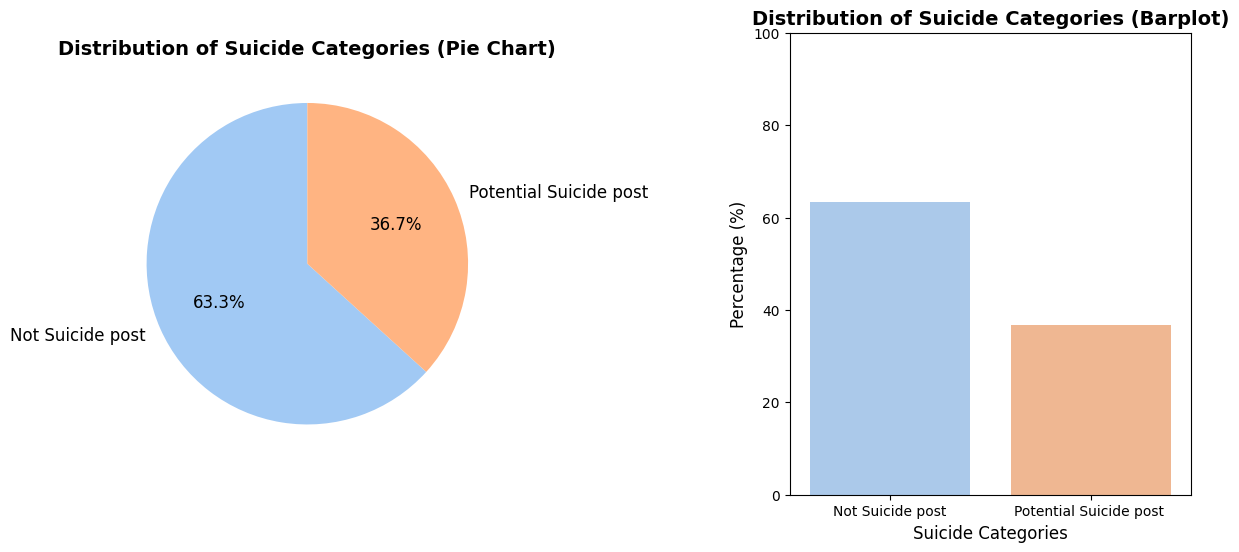

In [14]:
# Visualisasi distribusi label
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 baris, 2 kolom
plt.subplots_adjust(wspace=0.7)

colors = sns.color_palette("pastel")
axes[0].pie(percentages, labels=categories, autopct='%.1f%%', colors=colors, startangle=90, textprops={'fontsize': 12})
axes[0].set_title("Distribution of Suicide Categories (Pie Chart)", fontsize=14, weight='bold')

sns.barplot(x=categories, y=percentages, palette="pastel", ax=axes[1])
axes[1].set_ylabel("Percentage (%)", fontsize=12)
axes[1].set_xlabel("Suicide Categories", fontsize=12)
axes[1].set_title("Distribution of Suicide Categories (Barplot)", fontsize=14, weight='bold')
axes[1].set_ylim(0, 100)
axes[1].tick_params(axis='x', labelsize=10)

plt.show()


37% dari data dikategorikan ke dalam label "Potential Suicide Post", sedangkan sisanya sebesar 63% masuk ke dalam label "Not Suicide Post". Proporsi ini dapat dianggap cukup seimbang, yang berarti model pembelajaran mesin yang dibangun nantinya diharapkan dapat belajar dengan baik dari kedua kelas label.

# **3. Preprocessing Data**

Tujuan preprocessing data adalah untuk meningkatkan kualitas data teks sehingga lebih mudah diproses oleh algoritma machine learning atau model lainnya.
Proses ini mencakup beberapa langkah utama.

*   Normalisasi data dilakukan untuk menyamakan format teks, seperti mengubah huruf besar menjadi huruf kecil, menghapus karakter khusus, atau mengganti kata-kata slang dengan bentuk standarnya, sehingga membantu mengurangi variasi data yang tidak relevan.  
*   Tokenisasi adalah proses memecah teks menjadi unit-unit kecil, seperti kata atau frasa, untuk mempermudah analisis pada level yang lebih granular.

*   Stop word removal bertujuan untuk menghapus kata-kata umum seperti "dan," "atau," dan "yang" yang tidak memiliki makna signifikan dalam analisis sentimen, sehingga fokus dapat diberikan pada kata-kata yang lebih informatif.
*   Lemmatization dilakukan untuk mengubah kata ke bentuk dasarnya (lemma), sehingga kata-kata dengan makna yang sama, seperti "running" dan "run," dianggap sebagai satu entitas. Dengan menerapkan langkah-langkah preprocessing ini, data menjadi lebih bersih, seragam, dan relevan untuk mendukung analisis sentimen yang lebih akurat dan efisien.

## **Normalisasi Text**

Tahap selanjutnya adalah membersihkan dan menormalisasi teks pada kolom 'Tweet' dalam dataset. Proses normalisasi ini melibatkan beberapa langkah, seperti mengubah semua teks menjadi huruf kecil, menghapus emoji, mention, hashtag, URL, dan karakter khusus lainnya. Tujuan utama dari normalisasi teks adalah untuk mempersiapkan data teks agar lebih siap untuk diproses lebih lanjut. Tujuan dari membersihkan teks dari noise dan ketidakkonsistenan adalah agar model yang dihasilkan akan lebih akurat dan andal.

In [15]:
df.head()

,Tweet,Suicide
0,making some lunch,Not Suicide post
1,@Alexia You want his money.,Not Suicide post
2,@dizzyhrvy that crap took me forever to put to...,Potential Suicide post
3,@jnaylor #kiwitweets Hey Jer! Since when did y...,Not Suicide post
4,Trying out &quot;Delicious Library 2&quot; wit...,Not Suicide post


In [16]:
# Kamus kata
slang_dict = {
    "u": "you",
    "omg": "oh my god",
    "bff": "best friend forever",
    "gonna": "going to",
    "wanna": "want to",
    "idk": "i don't know",
    "brb": "be right back",
    "otw": "on the way",
}

In [17]:
def normalize_text(text):
  text = text.lower()
  text = emoji.demojize(text)
  text = re.sub(r'@[A-Za-z0-9_]+', '', text)
  text = re.sub(r'#\w+', '', text)
  text = re.sub(r'rt[\s]+', '', text)
  text = re.sub(r'https?://\S+', '', text)
  text = re.sub(r'[^A-Za-z0-9\' ]', '', text)
  text = re.sub(r'\s+', ' ', text).strip()

  # Normalisasi slang
  words = text.split()
  normalized_words = [slang_dict[word] if word in slang_dict else word for word in words]

  return ' '.join(normalized_words)

In [18]:
# Contoh hasil dari clean text
print(normalize_text("RT @user: I'm sure this is a test for u! Check http://example.com #example 😊"))

i'm sure this is a test for you check smilingfacewithsmilingeyes


In [19]:
# Clean twitter text
df['Tweet'] = df['Tweet'].apply(normalize_text)
df.head()

,Tweet,Suicide
0,making some lunch,Not Suicide post
1,you want his money,Not Suicide post
2,that crap took me forever to put together im g...,Potential Suicide post
3,hey jer since when did you statwittering,Not Suicide post
4,trying out quotdelicious library 2quot with mi...,Not Suicide post


## **Tokenization**

Tokenisasi adalah proses memecah teks menjadi unit-unit kecil yang disebut token, seperti kata, frasa, atau bahkan karakter. Proses ini penting karena memungkinkan analisis dilakukan pada tingkat elemen teks yang lebih terperinci. Misalnya, kalimat "Saya suka belajar AI" dapat dipecah menjadi ["Saya", "suka", "belajar", "AI"]. Tokenisasi yang tepat membantu model memahami struktur data teks dengan lebih baik.

In [20]:
# Tokenized text
df['Clean_Tweet'] = df['Tweet'].apply(word_tokenize)

df[['Tweet', 'Clean_Tweet']].head()

,Tweet,Clean_Tweet
0,making some lunch,"[making, some, lunch]"
1,you want his money,"[you, want, his, money]"
2,that crap took me forever to put together im g...,"[that, crap, took, me, forever, to, put, toget..."
3,hey jer since when did you statwittering,"[hey, jer, since, when, did, you, statwittering]"
4,trying out quotdelicious library 2quot with mi...,"[trying, out, quotdelicious, library, 2quot, w..."


## **Stopword removal**

Stop word removal adalah langkah untuk menghapus kata-kata umum yang sering muncul dalam teks tetapi tidak memberikan makna khusus untuk analisis. Contohnya, dalam bahasa Indonesia, kata-kata seperti "dan", "yang", atau "itu" cenderung tidak berkontribusi pada pemahaman konteks atau emosi dari suatu teks. Menghapus stop word bertujuan untuk mengurangi dimensi data dan fokus hanya pada kata-kata penting yang lebih relevan.

In [21]:
# Check Stopword yang ada di library nltk
stop_words = set(stopwords.words('english'))
print(stop_words)

{'so', 'she', 'there', "don't", 'does', 'be', "he'll", 'above', 'has', "they've", 'been', 'if', 'under', 'up', 'when', 'his', 'or', 'few', 'of', 'isn', 'during', "it'll", 'them', 'down', "that'll", 'they', 'were', 'over', 'against', 'same', 'yours', 'd', "you'll", 'that', 'your', "it'd", 'itself', "doesn't", 'too', 'won', 'own', 'was', 'you', 'him', 'theirs', "we'll", 'needn', 'and', 'himself', 'how', 'my', 'having', 'm', "we've", 'on', "shan't", "weren't", "she's", "didn't", 'for', 'through', 'about', 'i', 'weren', 'ain', 'into', 'the', "wasn't", 'from', 'more', 'ourselves', "you've", 'as', "mightn't", 'here', 'which', "mustn't", 'just', 'yourself', 'had', 'doesn', 'haven', 'not', 'then', 'while', 'any', "it's", "should've", 'where', 't', 'is', 'an', 'before', 'her', 'am', 'a', "hasn't", "she'll", 'all', 'mustn', "you're", 'off', 'our', 'now', 'after', 'these', "they'd", 'again', 'do', 'being', 'should', 'mightn', "isn't", 'this', 'ma', 'yourselves', 'no', "needn't", 'hasn', 'he', 'o'

In [22]:
df['Clean_Tweet'] = df['Clean_Tweet'].apply(lambda tokens: [word for word in tokens if word.lower() not in stop_words])
df[['Tweet', 'Clean_Tweet']].head()

,Tweet,Clean_Tweet
0,making some lunch,"[making, lunch]"
1,you want his money,"[want, money]"
2,that crap took me forever to put together im g...,"[crap, took, forever, put, together, im, going..."
3,hey jer since when did you statwittering,"[hey, jer, since, statwittering]"
4,trying out quotdelicious library 2quot with mi...,"[trying, quotdelicious, library, 2quot, mixed,..."


## **Lemmatization**

Lemmatization adalah proses untuk mengembalikan kata ke bentuk dasarnya atau bentuk lemma berdasarkan maknanya dalam kalimat. Misalnya, kata "berlari," "berlari-lari," dan "berlarian" semuanya akan diubah menjadi "lari" sebagai bentuk dasarnya. Proses ini membantu mengurangi redundansi dalam data teks, sehingga model dapat fokus pada makna inti kata tanpa terganggu oleh variasi bentuk kata tersebut.

In [23]:
lemmatizer = WordNetLemmatizer()
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

In [24]:
df['Clean_Tweet'] = df['Clean_Tweet'].apply(lemmatize_tokens)
df[['Tweet', 'Clean_Tweet']].head()

,Tweet,Clean_Tweet
0,making some lunch,"[making, lunch]"
1,you want his money,"[want, money]"
2,that crap took me forever to put together im g...,"[crap, took, forever, put, together, im, going..."
3,hey jer since when did you statwittering,"[hey, jer, since, statwittering]"
4,trying out quotdelicious library 2quot with mi...,"[trying, quotdelicious, library, 2quot, mixed,..."


In [25]:
# gabungkan list Clean_Tweet
df["Clean_Tweet"] = df["Clean_Tweet"].apply(lambda x: ' '.join(x))
df.head()

,Tweet,Suicide,Clean_Tweet
0,making some lunch,Not Suicide post,making lunch
1,you want his money,Not Suicide post,want money
2,that crap took me forever to put together im g...,Potential Suicide post,crap took forever put together im going go sle...
3,hey jer since when did you statwittering,Not Suicide post,hey jer since statwittering
4,trying out quotdelicious library 2quot with mi...,Not Suicide post,trying quotdelicious library 2quot mixed resul...


## **Visualisasi**

In [26]:
from wordcloud import WordCloud, STOPWORDS

def plot_cloud(wordcloud):
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

Wordcloud gabungan dari label "Potential Suicide post" dan "Not Suicide post"

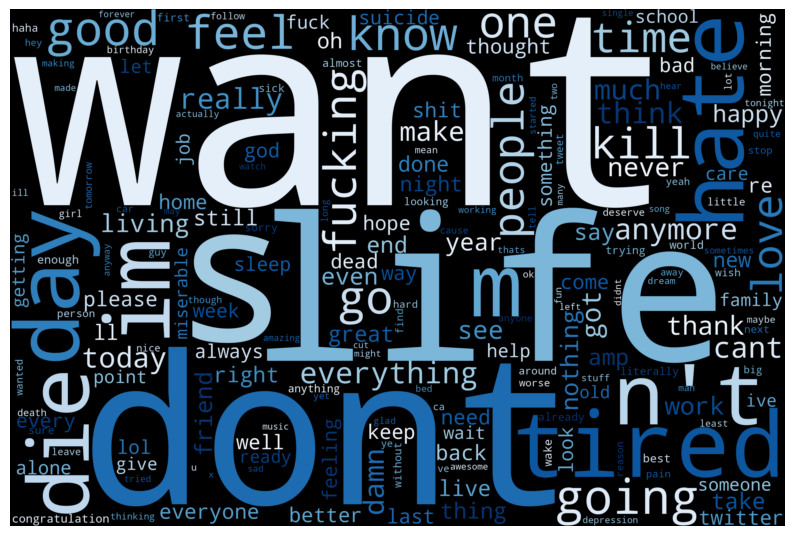

In [27]:
all_words = ' '.join([tweets for tweets in df['Clean_Tweet']])

wordcloud = WordCloud(
    width=3000,
    height=2000,
    random_state=3,
    background_color='black',
    colormap='Blues_r',
    collocations=False,
    stopwords=STOPWORDS
).generate(all_words)

plot_cloud(wordcloud)

Wordcloud "Not Suicide Post"


--- Word Cloud untuk Kelas: Not Suicide Post ---


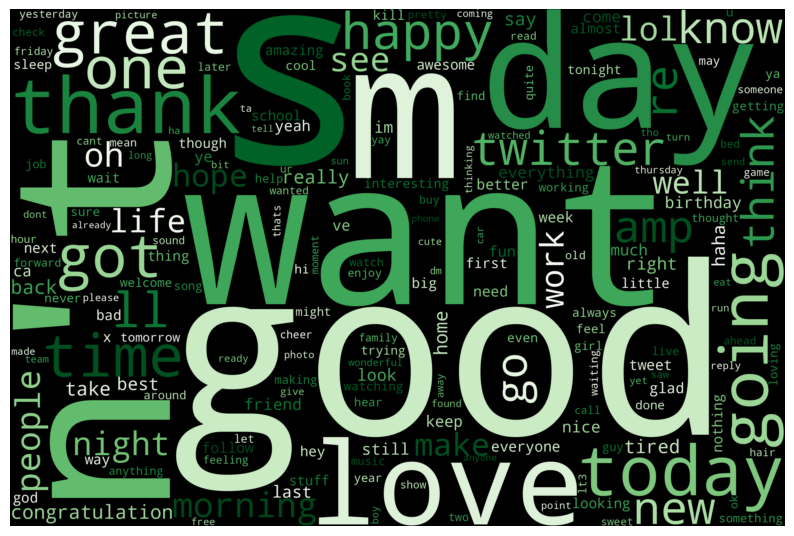

In [28]:
# Filter teks yang hanya termasuk kelas "Not Suicide post"
not_suicide_text = df[df['Suicide'] == 'Not Suicide post']['Clean_Tweet']

# Gabungkan semua teks menjadi satu string panjang
all_not_suicide_text = ' '.join([tweets for tweets in not_suicide_text])

# Buat objek WordCloud
wordcloud_not_suicide = WordCloud(
    width=3000,
    height=2000,
    random_state=3,
    background_color='black',
    colormap='Greens',
    collocations=False,
    stopwords=STOPWORDS
).generate(all_not_suicide_text)

print("\n--- Word Cloud untuk Kelas: Not Suicide Post ---")
plot_cloud(wordcloud_not_suicide)


Wordcloud "Potential Suicide Post"

--- Word Cloud untuk Kelas: Potential Suicide Post ---


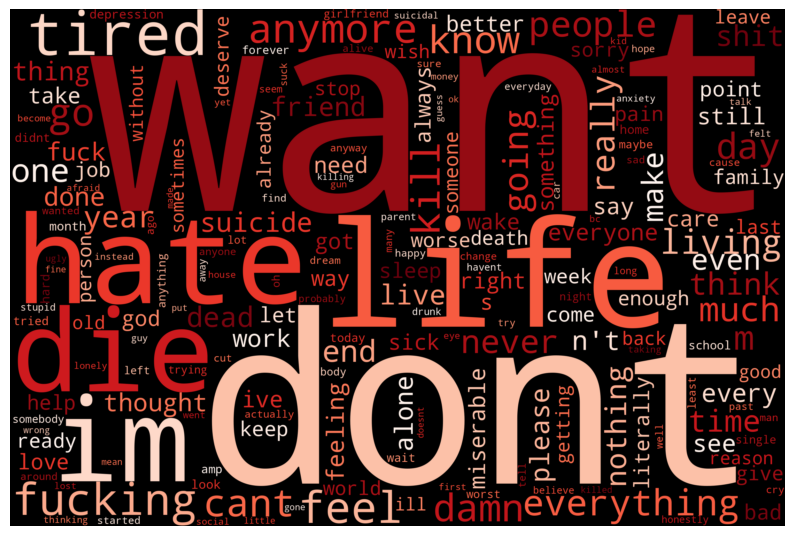

In [29]:
# Filter teks yang hanya termasuk kelas "Potential Suicide post "

potential_suicide_text = df[df['Suicide'] == 'Potential Suicide post ']['Clean_Tweet']

# Gabungkan semua teks menjadi satu string panjang
all_potential_text = ' '.join([tweets for tweets in potential_suicide_text])

# Buat objek WordCloud
wordcloud_potential = WordCloud(
    width=3000,
    height=2000,
    random_state=3,
    background_color='black',
    colormap='Reds',
    collocations=False,
    stopwords=STOPWORDS
).generate(all_potential_text)

# Tampilkan Word Cloud
print("--- Word Cloud untuk Kelas: Potential Suicide Post ---")
plot_cloud(wordcloud_potential)

# **4. Membangun model machine learning**

Menggunakan 2 model Machine Learning pada klasifikasi ini, yaitu Multinomial Naive Bayes dan Decision Tree Classifier. Berikut merupakan pertimbangan menggunakan kedua model tersebut:

*   Multinomial Naive Bayes (MNB): Multinomial Naive Bayes adalah model yang sering digunakan dalam analisis teks, termasuk sentiment analysis, karena kemampuannya yang efisien dalam menangani data berbasis frekuensi kata. MNB bekerja berdasarkan prinsip probabilitas, di mana setiap fitur (kata) diasumsikan independen satu sama lain. Keunggulan utama MNB adalah kesederhanaannya, efisiensi komputasi, dan kemampuan untuk menangani dataset dengan dimensi yang tinggi.

*   Decision Tree (DT): Decision Tree adalah model berbasis pohon yang melakukan prediksi dengan memecah data secara rekursif berdasarkan aturan-aturan sederhana yang diperoleh dari fitur dataset. Dalam sentiment analysis, Decision Tree bekerja dengan membangun jalur keputusan yang menghubungkan fitur (kata atau frasa tertentu) dengan label sentimen (misalnya, positif, negatif, atau netral). Salah satu kelebihan Decision Tree adalah kemampuannya untuk menangkap hubungan non-linear antar fitur dan membuat keputusan yang mudah dipahami oleh manusia, karena pohon keputusan dapat divisualisasikan.

In [30]:
data = df.drop("Tweet", axis=1)
data.head()

,Suicide,Clean_Tweet
0,Not Suicide post,making lunch
1,Not Suicide post,want money
2,Potential Suicide post,crap took forever put together im going go sle...
3,Not Suicide post,hey jer since statwittering
4,Not Suicide post,trying quotdelicious library 2quot mixed resul...


## **Split data**

Langkah selanjutnya adalah melakukan pembagian data (data splitting) dengan proporsi 80% untuk data latih (training data) dan 20% untuk data uji (test data). Pendekatan ini bertujuan untuk memastikan bahwa model dilatih dan diuji pada data yang representatif terhadap distribusi kelas dalam dataset asli, sehingga hasil evaluasi model menjadi lebih akurat dan adil.

In [31]:
# Split data
not_suicide_df = data[data["Suicide"] == "Not Suicide post"]
potential_post_df = data[data["Suicide"] == "Potential Suicide post "]

not_suicide_train, not_suicide_test = train_test_split(not_suicide_df, test_size=0.2, random_state=42)
potential_post_train, potential_post_test = train_test_split(potential_post_df, test_size=0.2, random_state=42)

train = pd.concat([not_suicide_train, potential_post_train])
test = pd.concat([not_suicide_test, potential_post_test])

train_shuffle = shuffle(train, random_state=42)
test_shuffle = shuffle(test, random_state=42)

X_train = train_shuffle["Clean_Tweet"]
y_train = train_shuffle["Suicide"]
X_test = test_shuffle["Clean_Tweet"]
y_test = test_shuffle["Suicide"]

In [32]:
print("X Train data:", X_train.shape[0])
print("y Train data:", y_train.shape[0])
print("=====================")
print("X Test data:", X_test.shape[0])
print("y Test data:", y_test.shape[0])

X Train data: 1421
y Train data: 1421
X Test data: 356
y Test data: 356


## **Vectorizer**

Setelah melakukan pembagian data, langkah selanjutnya adalah melakukan vektorisasi pada data latih dan data uji. Sederhananya, vektorisasi mengubah teks (yang bersifat kualitatif) menjadi representasi numerik (vektor) yang dapat dipahami oleh model pembelajaran mesin. Dalam hal ini, kami menggunakan TF-IDF Vectorizer (Term Frequency-Inverse Document Frequency) untuk mengubah teks menjadi representasi numerik yang dapat diproses oleh model machine learning.

TF-IDF Vectorizer adalah teknik yang umum digunakan dalam pengolahan teks untuk mengubah data teks mentah (seperti kalimat atau dokumen) menjadi vektor angka. Proses ini terdiri dari dua komponen utama:

*   Term Frequency (TF): TF mengukur seberapa sering suatu kata muncul dalam suatu dokumen. Semakin sering kata tersebut muncul dalam dokumen, semakin tinggi nilai TF-nya. Ini mencerminkan pentingnya kata tersebut dalam konteks dokumen tertentu.
*   Inverse Document Frequency (IDF): IDF mengukur seberapa penting suatu kata dalam seluruh korpus dokumen. Kata-kata yang sering muncul di banyak dokumen akan mendapatkan nilai IDF yang rendah, sedangkan kata-kata yang jarang muncul di seluruh dokumen akan mendapatkan nilai IDF yang lebih tinggi. IDF membantu mengurangi bobot kata-kata umum yang tidak memberikan informasi signifikan.




In [33]:
# Stopword removal pakai sklearn
# Vectorizer TfidfVectorizer CountVectorizer
vectorizer = TfidfVectorizer(stop_words='english')
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

In [34]:
joblib.dump(vectorizer, 'vectorizer_temp.pkl')

['vectorizer_temp.pkl']

## **Naive Bayes (Multinomial Naive Bayes)**

In [35]:
model = MultinomialNB()
model.fit(X_train_vect, y_train)

MultinomialNB()

## **Evaluasi Model**

In [36]:
y_pred = model.predict(X_test_vect)
y_pred[:5]

array(['Potential Suicide post ', 'Not Suicide post',
       'Potential Suicide post ', 'Not Suicide post', 'Not Suicide post'],
      dtype='<U23')

In [37]:
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

       Not Suicide post       0.90      0.93      0.92       225
Potential Suicide post        0.88      0.82      0.85       131

               accuracy                           0.89       356
              macro avg       0.89      0.88      0.88       356
           weighted avg       0.89      0.89      0.89       356



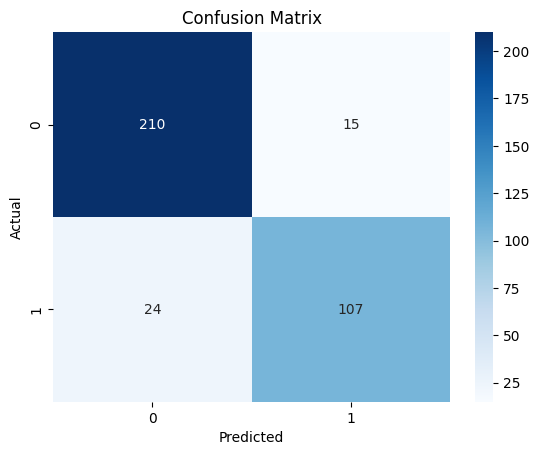

In [38]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [39]:
y_pred_train_NB = model.predict(X_train_vect)
print(classification_report(y_train, y_pred_train_NB))

                         precision    recall  f1-score   support

       Not Suicide post       0.98      0.99      0.98       899
Potential Suicide post        0.97      0.97      0.97       522

               accuracy                           0.98      1421
              macro avg       0.98      0.98      0.98      1421
           weighted avg       0.98      0.98      0.98      1421



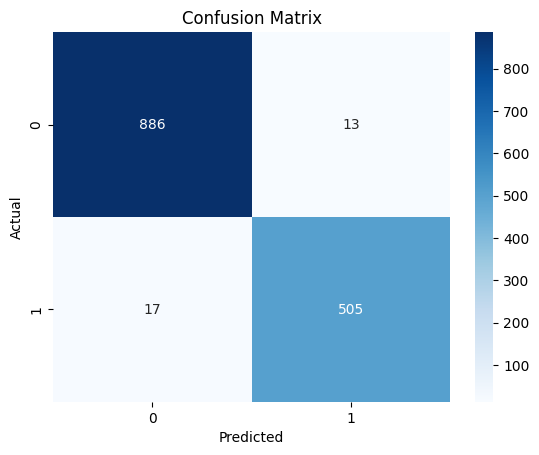

In [40]:
sns.heatmap(confusion_matrix(y_train, y_pred_train_NB), annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**Model Multinomial Naive Bayes** telah menunjukkan hasil yang cukup memuaskan, dengan akurasi sebesar 89% pada data train dan 98% pada data test. Namun, perbedaan yang cukup signifikan antara akurasi data train dan data test menunjukkan potensi overfitting. Hal ini mengindikasikan bahwa model mungkin terlalu terfokus pada pola-pola spesifik dalam data train, sehingga kurang mampu menangkap variasi yang lebih umum pada data baru. Untuk mengatasi masalah ini, langkah-langkah seperti pengurangan fitur yang kurang relevan, penggunaan teknik regularisasi, atau pengujian model dengan Cross Validation dapat dilakukan untuk meningkatkan generalisasi model.

## **Tuning Parameter pada Model Multinomial Naive Bayes (GridSearchCV)**

Untuk meningkatkan performa model Multinomial Naive Bayes, atur parameter alpha dengan memanfaatkan Grid Search dan Bayesian Optimization. Grid Search digunakan untuk mengevaluasi performa model pada berbagai nilai alpha yang telah ditentukan sebelumnya, sehingga dapat menemukan kombinasi terbaik melalui pencarian sistematis. Sementara itu, Bayesian Optimization diterapkan untuk mengoptimalkan nilai alpha secara lebih efisien dengan menggunakan metode probabilistik yang meminimalkan jumlah evaluasi yang diperlukan. Pendekatan ini membantu menemukan nilai alpha optimal yang memberikan keseimbangan terbaik antara bias dan varians pada model, sehingga meningkatkan akurasi dan generalisasi.

In [41]:
# Hyperparameter tuning untuk alpha
params = {
    'alpha': [0.1, 0.4, 0.54, 0.55, 0.6, 0.65, 1.0, 5.0, 10.0]
}
mnb = MultinomialNB()
grid_search = GridSearchCV(mnb, param_grid=params, cv=5, scoring='accuracy')
grid_search.fit(X_train_vect, y_train)

print("Best alpha:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best alpha: {'alpha': 0.55}
Best Score: 0.8895305164319248


## **MultinomialNB Model with best params (GridSearchCV)**

In [42]:
mnb_tuned = MultinomialNB(**grid_search.best_params_)
mnb_tuned.fit(X_train_vect, y_train)

MultinomialNB(alpha=0.55)

In [43]:
y_pred_tuned_mnb = mnb_tuned.predict(X_test_vect)
print(classification_report(y_test, y_pred_tuned_mnb))

                         precision    recall  f1-score   support

       Not Suicide post       0.90      0.88      0.89       225
Potential Suicide post        0.80      0.84      0.82       131

               accuracy                           0.87       356
              macro avg       0.85      0.86      0.86       356
           weighted avg       0.87      0.87      0.87       356



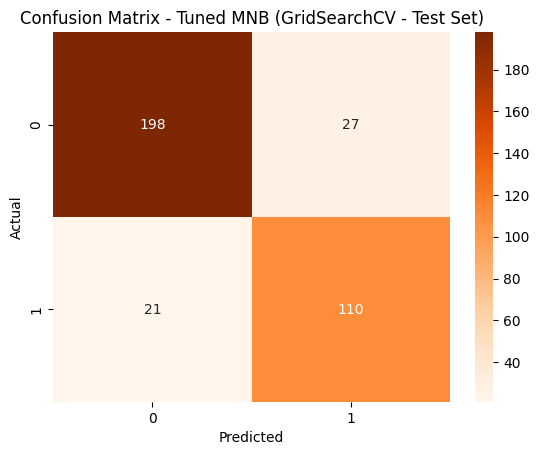

In [44]:
sns.heatmap(confusion_matrix(y_test, y_pred_tuned_mnb), annot=True, fmt='g', cmap='Oranges')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Tuned MNB (GridSearchCV - Test Set)')
plt.show()

In [45]:
y_pred_train_tuned_mnb = mnb_tuned.predict(X_train_vect)
print(classification_report(y_train, y_pred_train_tuned_mnb))

                         precision    recall  f1-score   support

       Not Suicide post       0.99      0.98      0.99       899
Potential Suicide post        0.97      0.98      0.98       522

               accuracy                           0.98      1421
              macro avg       0.98      0.98      0.98      1421
           weighted avg       0.98      0.98      0.98      1421



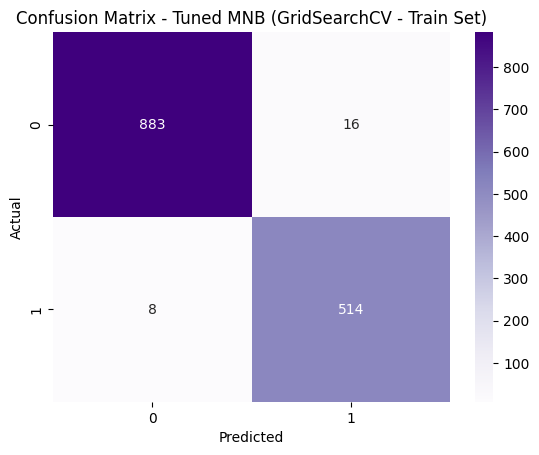

In [46]:
sns.heatmap(confusion_matrix(y_train, y_pred_train_tuned_mnb), annot=True, fmt='g', cmap='Purples')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Tuned MNB (GridSearchCV - Train Set)')
plt.show()

## **Tuning Parameter pada Model Multinomial Naive Bayes (BayesianOptimization)**

In [47]:
space = {
    'alpha': (0.1, 5.0)
}

clf = MultinomialNB()

opt = BayesSearchCV(
    clf,
    space,
    n_iter=150,  # Jumlah iterasi
    cv=5,
    scoring='accuracy'
)

opt.fit(X_train_vect, y_train)

# Hyperparameter terbaik
print("Best parameters:", opt.best_params_)

Best parameters: OrderedDict([('alpha', 0.5749530865821042)])


## **MultinomialNB Model with best params (BayesianOptimization)**

In [48]:
mnb_tuned = MultinomialNB(**opt.best_params_)
mnb_tuned.fit(X_train_vect, y_train)

MultinomialNB(alpha=0.5749530865821042)

In [49]:
y_pred_tuned_mnb = mnb_tuned.predict(X_test_vect)
print(classification_report(y_test, y_pred_tuned_mnb))

                         precision    recall  f1-score   support

       Not Suicide post       0.90      0.88      0.89       225
Potential Suicide post        0.81      0.84      0.82       131

               accuracy                           0.87       356
              macro avg       0.86      0.86      0.86       356
           weighted avg       0.87      0.87      0.87       356



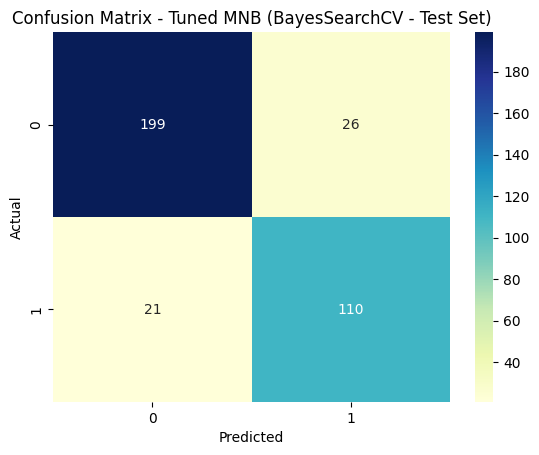

In [50]:
sns.heatmap(confusion_matrix(y_test, y_pred_tuned_mnb), annot=True, fmt='g', cmap='YlGnBu')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Tuned MNB (BayesSearchCV - Test Set)')
plt.show()

In [51]:
y_pred_train_tuned_mnb = mnb_tuned.predict(X_train_vect)
print(classification_report(y_train, y_pred_train_tuned_mnb))

                         precision    recall  f1-score   support

       Not Suicide post       0.99      0.98      0.99       899
Potential Suicide post        0.97      0.98      0.98       522

               accuracy                           0.98      1421
              macro avg       0.98      0.98      0.98      1421
           weighted avg       0.98      0.98      0.98      1421



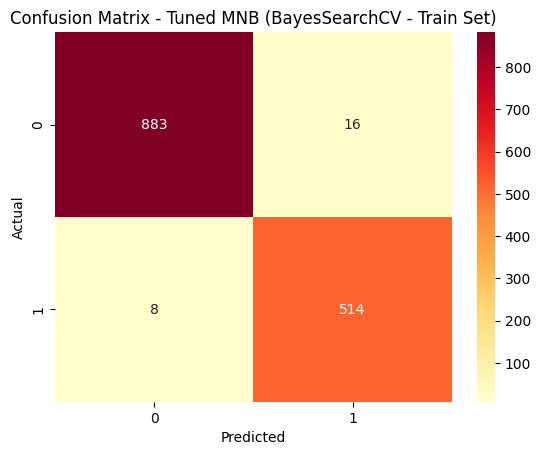

In [52]:
sns.heatmap(confusion_matrix(y_train, y_pred_train_tuned_mnb), annot=True, fmt='g', cmap='YlOrRd')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Tuned MNB (BayesSearchCV - Train Set)')
plt.show()

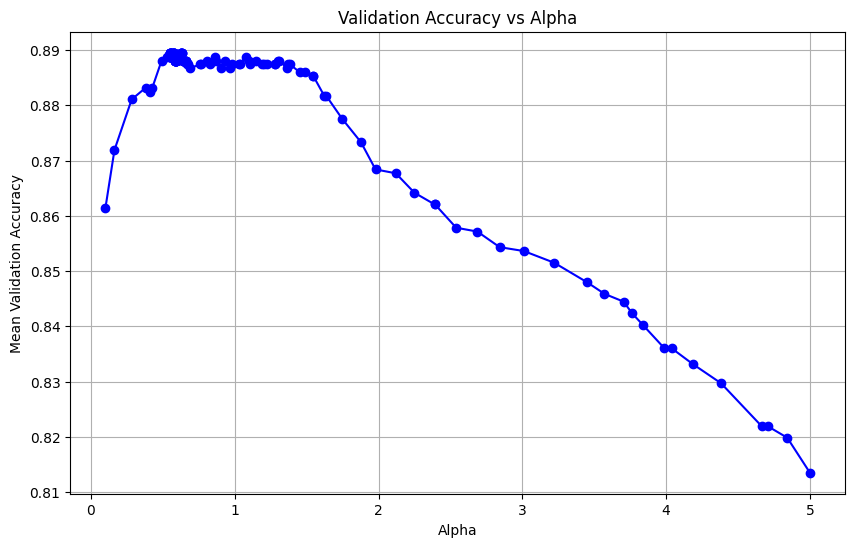

In [53]:
# Ekstrak hasil dari opt.cv_results_
cv_results = opt.cv_results_

# Ambil nilai parameter alpha dan skor validasi rata-rata
alphas = cv_results['param_alpha'].data
mean_test_scores = cv_results['mean_test_score']

# Sortir data berdasarkan alpha untuk visualisasi yang rapi
sorted_indices = np.argsort(alphas)
alphas_sorted = np.array(alphas)[sorted_indices]
scores_sorted = np.array(mean_test_scores)[sorted_indices]

# Plot hasilnya
plt.figure(figsize=(10, 6))
plt.plot(alphas_sorted, scores_sorted, marker='o', linestyle='-', color='b')
plt.title('Validation Accuracy vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Mean Validation Accuracy')
plt.grid(True)
plt.show()

Hasil tuning menunjukkan bahwa parameter alpha terbaik untuk model Multinomial Naive Bayes berada dalam rentang 0.5 hingga 0.6. Namun, performa model dengan alpha tersebut tidak menunjukkan peningkatan yang signifikan dibandingkan model dengan parameter default. Hal ini mengindikasikan bahwa meskipun nilai alpha yang dipilih telah dioptimalkan melalui Grid Search dan Bayesian Optimization, pengaruhnya terhadap akurasi model cenderung minimal. Model tetap menghasilkan hasil yang mirip, baik dalam hal akurasi maupun generalisasi pada data train dan test.

## **DecisionTree Classifier**

In [54]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_vect, y_train)

DecisionTreeClassifier(random_state=42)

## **Evaluasi Model**

Saat menggunakan model Decision Tree dengan parameter default, diperoleh akurasi sebesar 89% pada data train dan 100% pada data test. Hasil ini menunjukkan adanya overfitting, di mana model terlalu menyesuaikan diri dengan data train sehingga kurang mampu menangkap pola umum yang berlaku untuk data baru. Hal ini mengindikasikan perlunya penyesuaian parameter untuk mengurangi kompleksitas model dan meningkatkan generalisasi.

In [55]:
y_pred_tree = dt.predict(X_test_vect)
print(classification_report(y_test, y_pred_tree))

                         precision    recall  f1-score   support

       Not Suicide post       0.90      0.93      0.92       225
Potential Suicide post        0.87      0.83      0.85       131

               accuracy                           0.89       356
              macro avg       0.89      0.88      0.88       356
           weighted avg       0.89      0.89      0.89       356



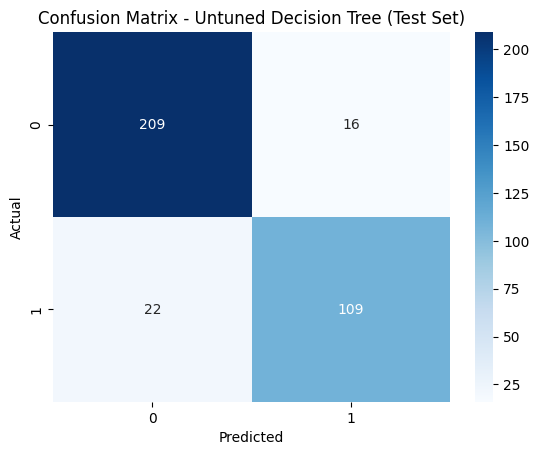

In [56]:
sns.heatmap(confusion_matrix(y_test, y_pred_tree), annot=True, fmt='g', cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Untuned Decision Tree (Test Set)')
plt.show()

In [57]:
y_pred_train_tree = dt.predict(X_train_vect)
print(classification_report(y_train, y_pred_train_tree))

                         precision    recall  f1-score   support

       Not Suicide post       1.00      1.00      1.00       899
Potential Suicide post        1.00      1.00      1.00       522

               accuracy                           1.00      1421
              macro avg       1.00      1.00      1.00      1421
           weighted avg       1.00      1.00      1.00      1421



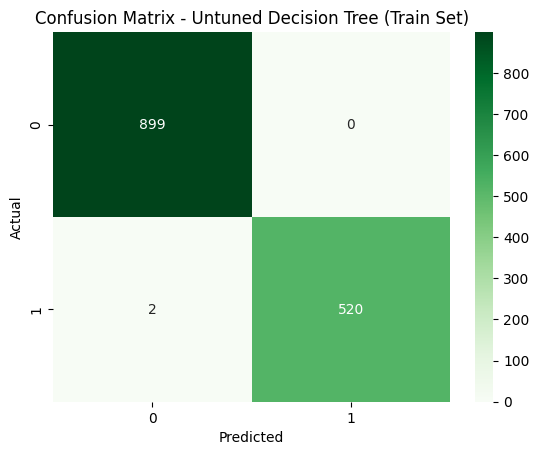

In [58]:
sns.heatmap(confusion_matrix(y_train, y_pred_train_tree), annot=True, fmt='g', cmap='Greens')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Untuned Decision Tree (Train Set)')
plt.show()


## **Tuning Parameter pada Decision Tree**

Langkah selanjutnya dalam meningkatkan performa model Decision Tree adalah melakukan hyperparameter tuning menggunakan Grid Search dengan Cross Validation 5-fold. Proses ini melibatkan eksplorasi berbagai kombinasi parameter, seperti max_depth, min_samples_split, min_samples_leaf, max_leaf_nodes, dan criterion, untuk menemukan konfigurasi optimal yang dapat meningkatkan kemampuan model dalam menggeneralisasi data. Dengan menggunakan Cross Validation, performa model dievaluasi secara lebih menyeluruh pada berbagai subset data, sehingga dapat mengurangi risiko overfitting.

In [59]:
# Melakukan Pre Prune Tree
param_dist = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 15, 20, 30],
    'min_samples_leaf': [1, 5, 10, 20],
    'max_leaf_nodes': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, None],
    'criterion': ['gini', 'entropy']
}

GridSearch_tree = DecisionTreeClassifier(random_state=42)
grid_search_tree = GridSearchCV(estimator=GridSearch_tree, param_grid=param_dist, cv=5, verbose=2, n_jobs=-1, scoring="accuracy")

grid_search_tree.fit(X_train_vect, y_train)

# Hyperparameter terbaik
best_params = grid_search_tree.best_params_
print(f"Hyperparameter terbaik: {best_params}")
best_score = grid_search_tree.best_score_
print(f"Score Terbaik: {best_score}")

Fitting 5 folds for each of 1760 candidates, totalling 8800 fits
Hyperparameter terbaik: {'criterion': 'gini', 'max_depth': None, 'max_leaf_nodes': 35, 'min_samples_leaf': 1, 'min_samples_split': 15}
Score Terbaik: 0.8923251791450456


**GridSearchCV Summary**

Analisis lebih lanjut dilakukan untuk mengevaluasi pengaruh masing-masing parameter terhadap performa model. Dari plot yang dihasilkan, terlihat bahwa dua parameter yang paling berpengaruh adalah max_leaf_nodes dan min_samples_leaf. Untuk max_leaf_nodes, performa model mencapai skor maksimum pada nilai 35, di mana nilai yang lebih besar cenderung menurunkan akurasi. Sementara itu, min_samples_leaf memberikan skor maksimum pada nilai 15, dengan penurunan performa yang terlihat jika nilai ini melebihi 15. Penemuan ini menunjukkan pentingnya memilih nilai optimal untuk parameter tersebut guna menghindari overfitting atau underfitting, serta memastikan generalisasi model yang lebih baik.

In [60]:
results = pd.DataFrame(grid_search_tree.cv_results_)

print("=== GridSearchCV ===")
print(f"Total percobaan: {len(results)}")
print("\n5 Percobaan Terbaik Berdasarkan Mean Test Score:")
top_5 = results.sort_values(by="mean_test_score", ascending=False).head(5)
print(top_5[["params", "mean_test_score", "std_test_score"]])

=== GridSearchCV ===
Total percobaan: 1760

5 Percobaan Terbaik Berdasarkan Mean Test Score:
                                                params  mean_test_score  \
782  {'criterion': 'gini', 'max_depth': None, 'max_...         0.892325   
780  {'criterion': 'gini', 'max_depth': None, 'max_...         0.890917   
783  {'criterion': 'gini', 'max_depth': None, 'max_...         0.890213   
784  {'criterion': 'gini', 'max_depth': None, 'max_...         0.888809   
763  {'criterion': 'gini', 'max_depth': None, 'max_...         0.888105   

     std_test_score  
782        0.010626  
780        0.013214  
783        0.009350  
784        0.011714  
763        0.015020  


In [61]:
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.062033,0.002754,0.003042,0.000332,gini,5,5,1,2,"{'criterion': 'gini', 'max_depth': 5, 'max_lea...",0.8,0.788732,0.795775,0.795775,0.816901,0.799437,0.009452,1681
1,0.071852,0.012582,0.002820,0.000092,gini,5,5,1,5,"{'criterion': 'gini', 'max_depth': 5, 'max_lea...",0.8,0.788732,0.795775,0.795775,0.816901,0.799437,0.009452,1681
2,0.066255,0.001752,0.002810,0.000107,gini,5,5,1,15,"{'criterion': 'gini', 'max_depth': 5, 'max_lea...",0.8,0.788732,0.795775,0.795775,0.816901,0.799437,0.009452,1681
3,0.065273,0.001076,0.002724,0.000063,gini,5,5,1,20,"{'criterion': 'gini', 'max_depth': 5, 'max_lea...",0.8,0.788732,0.795775,0.795775,0.816901,0.799437,0.009452,1681
4,0.064938,0.000435,0.002743,0.000079,gini,5,5,1,30,"{'criterion': 'gini', 'max_depth': 5, 'max_lea...",0.8,0.788732,0.795775,0.795775,0.816901,0.799437,0.009452,1681


In [62]:
def merge_data(results, group_by_param, criteria):
    return (
        results[results["param_criterion"].isin(criteria)]
        .groupby([group_by_param, "param_criterion"])["mean_test_score"]
        .max()
        .reset_index()
        .rename(columns={"param_criterion": "criterion"})
    )

# Data untuk max_leaf_nodes
max_leaf_data = merge_data(results, "param_max_leaf_nodes", ["entropy", "gini"])

# Data untuk min_samples_split
min_split_data = merge_data(results, "param_min_samples_split", ["entropy", "gini"])

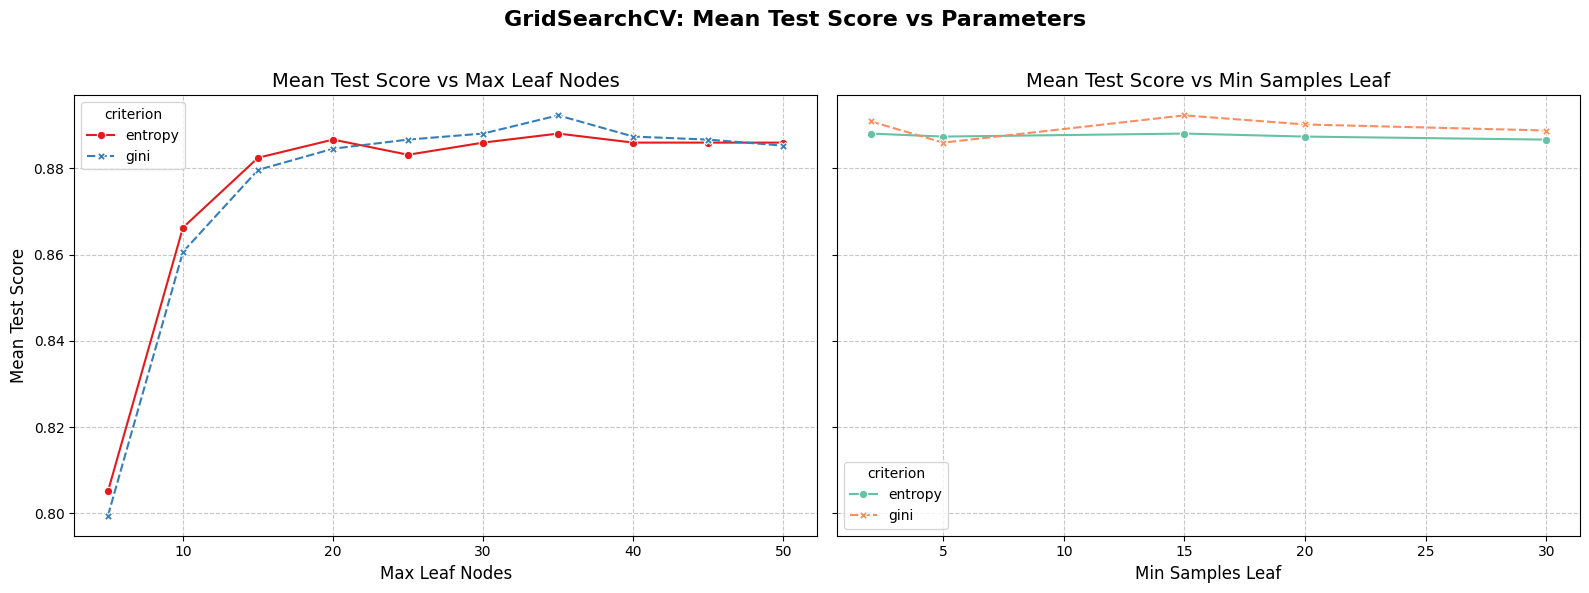

In [63]:
# Plotting menggunakan Seaborn
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot 1: Mean Test Score vs Max Leaf Nodes
sns.lineplot(
    data=max_leaf_data,
    x="param_max_leaf_nodes",
    y="mean_test_score",
    hue="criterion",
    style="criterion",
    markers=True,
    ax=axes[0],
    palette="Set1"
)
axes[0].set_title("Mean Test Score vs Max Leaf Nodes", fontsize=14)
axes[0].set_xlabel("Max Leaf Nodes", fontsize=12)
axes[0].set_ylabel("Mean Test Score", fontsize=12)
axes[0].grid(True, linestyle="--", alpha=0.7)

# Plot 2: Mean Test Score vs Min Samples Split
sns.lineplot(
    data=min_split_data,
    x="param_min_samples_split",
    y="mean_test_score",
    hue="criterion",
    style="criterion",
    markers=True,
    ax=axes[1],
    palette="Set2"
)
axes[1].set_title("Mean Test Score vs Min Samples Leaf", fontsize=14)
axes[1].set_xlabel("Min Samples Leaf", fontsize=12)
axes[1].grid(True, linestyle="--", alpha=0.7)

fig.suptitle("GridSearchCV: Mean Test Score vs Parameters", fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## **Model Tree with Best Params**

Hasil tuning menunjukkan peningkatan performa yang signifikan dibandingkan dengan model default. Model yang telah dioptimalkan mencapai akurasi sebesar 90% pada data test dan 93% pada data train. Perbedaan akurasi yang lebih kecil antara data train dan test ini menandakan bahwa model menjadi lebih seimbang dan tidak lagi terlalu terfokus pada data train. Dengan demikian, model memiliki kemampuan generalisasi yang lebih baik untuk data baru.

In [64]:
dt_prune = DecisionTreeClassifier(**best_params, random_state=42)
dt_prune.fit(X_train_vect, y_train)

DecisionTreeClassifier(max_leaf_nodes=35, min_samples_split=15, random_state=42)

In [65]:
y_pred_tree_prune = dt_prune.predict(X_test_vect)
print(classification_report(y_test, y_pred_tree_prune))

                         precision    recall  f1-score   support

       Not Suicide post       0.91      0.94      0.93       225
Potential Suicide post        0.89      0.85      0.87       131

               accuracy                           0.90       356
              macro avg       0.90      0.89      0.90       356
           weighted avg       0.90      0.90      0.90       356



In [66]:
y_pred_train_tree_prune = dt_prune.predict(X_train_vect)
print(classification_report(y_train, y_pred_train_tree_prune))

                         precision    recall  f1-score   support

       Not Suicide post       0.94      0.96      0.95       899
Potential Suicide post        0.93      0.89      0.91       522

               accuracy                           0.93      1421
              macro avg       0.93      0.92      0.93      1421
           weighted avg       0.93      0.93      0.93      1421



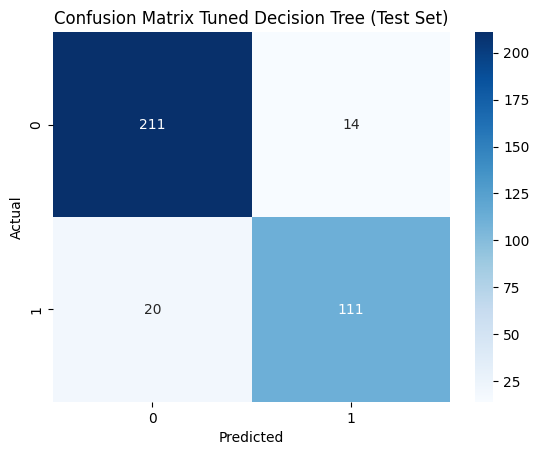

In [67]:
sns.heatmap(confusion_matrix(y_test, y_pred_tree_prune), annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Tuned Decision Tree (Test Set)')
plt.show()

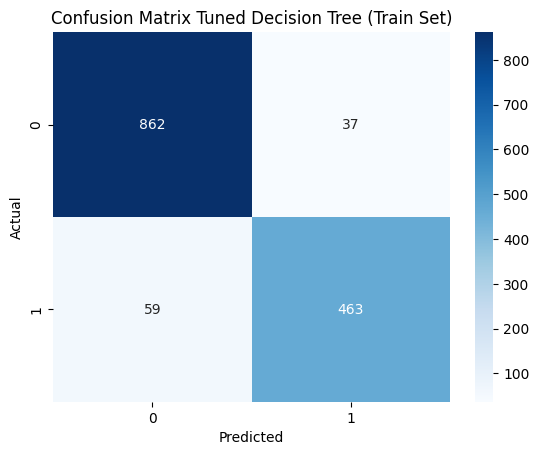

In [68]:
sns.heatmap(confusion_matrix(y_train, y_pred_train_tree_prune), annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Tuned Decision Tree (Train Set)')
plt.show()

## **Kurva ROC**

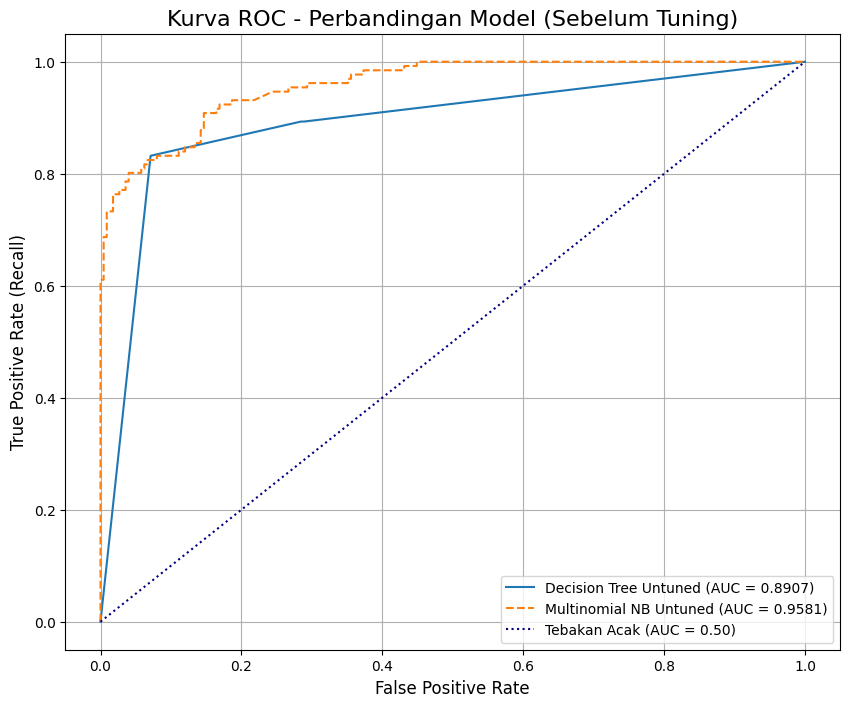

In [69]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Model memerlukan label dalam bentuk numerik (0 dan 1)
# Kita asumsikan kelas positif (1) adalah 'Potential Suicide post '
y_test_binary = y_test.apply(lambda x: 1 if x == 'Potential Suicide post ' else 0)


# ----- Dapatkan Probabilitas Prediksi dari model SEBELUM di-tuning -----
# Menggunakan objek 'dt' dan 'model'
dt_untuned_probs = dt.predict_proba(X_test_vect)[:, 1]
mnb_untuned_probs = model.predict_proba(X_test_vect)[:, 1]


# ----- Hitung Nilai ROC dan AUC untuk setiap model -----
fpr_dt_untuned, tpr_dt_untuned, _ = roc_curve(y_test_binary, dt_untuned_probs)
auc_dt_untuned = roc_auc_score(y_test_binary, dt_untuned_probs)

fpr_mnb_untuned, tpr_mnb_untuned, _ = roc_curve(y_test_binary, mnb_untuned_probs)
auc_mnb_untuned = roc_auc_score(y_test_binary, mnb_untuned_probs)


# ----- Membuat Plot Kurva ROC -----
plt.figure(figsize=(10, 8))

# Plot kurva Decision Tree (sebelum tuning)
plt.plot(fpr_dt_untuned, tpr_dt_untuned, linestyle='-', label=f'Decision Tree Untuned (AUC = {auc_dt_untuned:.4f})')

# Plot kurva Multinomial Naive Bayes (sebelum tuning)
plt.plot(fpr_mnb_untuned, tpr_mnb_untuned, linestyle='--', label=f'Multinomial NB Untuned (AUC = {auc_mnb_untuned:.4f})')

# Plot garis referensi (tebakan acak)
plt.plot([0, 1], [0, 1], color='navy', linestyle=':', label='Tebakan Acak (AUC = 0.50)')

plt.title('Kurva ROC - Perbandingan Model (Sebelum Tuning)', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


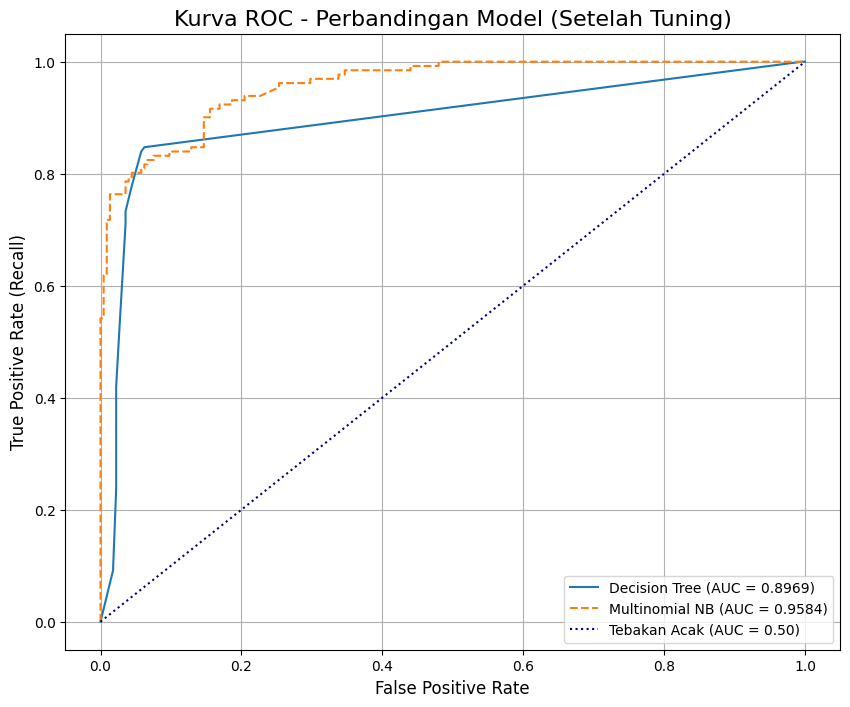

In [70]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Model memerlukan label dalam bentuk numerik (0 dan 1)
# Kita asumsikan kelas positif (1) adalah 'Potential Suicide post '
y_test_binary = y_test.apply(lambda x: 1 if x == 'Potential Suicide post ' else 0)


# ----- Dapatkan Probabilitas Prediksi untuk Kelas Positif -----
dt_probs = dt_prune.predict_proba(X_test_vect)[:, 1] # DT hasil tuning
mnb_probs = mnb_tuned.predict_proba(X_test_vect)[:, 1] # Menggunakan model MNB hasil tuning


# ----- Hitung Nilai ROC dan AUC untuk setiap model -----
fpr_dt, tpr_dt, _ = roc_curve(y_test_binary, dt_probs)
auc_dt = roc_auc_score(y_test_binary, dt_probs)

fpr_mnb, tpr_mnb, _ = roc_curve(y_test_binary, mnb_probs)
auc_mnb = roc_auc_score(y_test_binary, mnb_probs)

# ----- Membuat Plot Kurva ROC -----
plt.figure(figsize=(10, 8))

# Plot kurva Decision Tree
plt.plot(fpr_dt, tpr_dt, linestyle='-', label=f'Decision Tree (AUC = {auc_dt:.4f})')

# Plot kurva Multinomial Naive Bayes
plt.plot(fpr_mnb, tpr_mnb, linestyle='--', label=f'Multinomial NB (AUC = {auc_mnb:.4f})')

# Plot garis referensi (tebakan acak)
plt.plot([0, 1], [0, 1], color='navy', linestyle=':', label='Tebakan Acak (AUC = 0.50)')

plt.title('Kurva ROC - Perbandingan Model (Setelah Tuning)', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# **5. Coba prediksi menggunakan model yang telah dibangun**

In [71]:
def sentiment_analysis(text):
  text = normalize_text(text)
  text = word_tokenize(text)
  text = lemmatize_tokens(text)
  filtered_tokens = [word for word in text if word.lower() not in stop_words]
  text = ' '.join(filtered_tokens)
  clean_text = vectorizer.transform([text])
  return clean_text

In [72]:
# Contoh kalimat
# Life is so tiring. I don't see the point anymore
# There's no hope left. I might as well just end it all
# I'm so exhausted today. I just want to sleep all day.
text = input("Masukkan kalimat twitter anda: ")
print("Tuned Decision Tree Prediction: ", dt_prune.predict(sentiment_analysis(text)))
print("Tuned Multinomial Naive Bayes Prediction: ", mnb_tuned.predict(sentiment_analysis(text)))

Masukkan kalimat twitter anda: Life is so tiring. I don't see the point anymore
Tuned Decision Tree Prediction:  ['Potential Suicide post ']
Tuned Multinomial Naive Bayes Prediction:  ['Potential Suicide post ']


In [73]:
text = input("Masukkan kalimat twitter anda: ")
print("Tuned Decision Tree Prediction: ", dt_prune.predict(sentiment_analysis(text)))
print("Tuned Multinomial Naive Bayes Prediction: ", mnb_tuned.predict(sentiment_analysis(text)))

Masukkan kalimat twitter anda: There's no hope left. I might as well just end it all
Tuned Decision Tree Prediction:  ['Not Suicide post']
Tuned Multinomial Naive Bayes Prediction:  ['Potential Suicide post ']


In [74]:
text = input("Masukkan kalimat twitter anda: ")
print("Tuned Decision Tree Prediction: ", dt_prune.predict(sentiment_analysis(text)))
print("Tuned Multinomial Naive Bayes Prediction: ", mnb_tuned.predict(sentiment_analysis(text)))

Masukkan kalimat twitter anda: I'm so exhausted today. I just want to sleep all day.
Tuned Decision Tree Prediction:  ['Not Suicide post']
Tuned Multinomial Naive Bayes Prediction:  ['Not Suicide post']


## **Export kedua model**

In [75]:
joblib.dump(dt_prune, 'DecisionTree_Model.joblib')
joblib.dump(mnb_tuned, 'MultinomialNB_Model.joblib')

['MultinomialNB_Model.joblib']